# Complete Workflow: From Raw Data to Publication-Ready Analysis

## Learning Objectives

By the end of this notebook, you will be able to:

- Process raw position tracking data from start to finish
- Compute occupancy-normalized place fields (spatial firing rate maps)
- Analyze neural activity across multiple regions of interest
- Detect and characterize spatial tuning (place cells, grid cells)
- Compare neural representations across different maze compartments
- Create publication-quality visualizations
- Apply best practices for reproducible spatial analysis

**Estimated time: 40-50 minutes**

**This notebook integrates concepts from all previous notebooks into a complete real-world analysis pipeline.**

## Experimental Scenario

**Setup:** You've recorded neural activity (hippocampal place cells) from a rat exploring a plus maze. The maze has:
- 4 arms (North, South, East, West)
- A central junction
- Two reward locations (North and South arms)

**Data:**
- Position tracking at 30 Hz
- Spike times from 20 simultaneously recorded neurons
- 20 minute recording session

**Goal:** Identify place cells, characterize their firing fields, and analyze spatial selectivity.

## Setup and Imports

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from scipy.stats import pearsonr

from neurospatial import Environment

np.random.seed(42)
warnings.filterwarnings("ignore")  # Suppress minor warnings for cleaner output

plt.rcParams["figure.figsize"] = (16, 12)
plt.rcParams["font.size"] = 11
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14

## Step 1: Generate Synthetic Experimental Data

We'll simulate realistic tracking and neural data to demonstrate the workflow.

### 1.1 Simulate Position Tracking

In [2]:
def generate_plus_maze_trajectory(n_samples=36000, sampling_rate=30.0):
    """
    Generate realistic plus maze exploration trajectory.

    Parameters
    ----------
    n_samples : int
        Number of position samples (default 36000 = 20 min at 30 Hz).
    sampling_rate : float
        Sampling rate in Hz.

    Returns
    -------
    trajectory : ndarray, shape (n_samples, 2)
        X, Y positions in cm.
    timestamps : ndarray, shape (n_samples,)
        Time in seconds.
    """
    # Plus maze dimensions (in cm)

    # Define arm centers
    arm_centers = {
        "north": (50, 75),
        "south": (50, 25),
        "east": (75, 50),
        "west": (25, 50),
        "center": (50, 50),
    }

    trajectory = np.zeros((n_samples, 2))
    trajectory[0] = arm_centers["center"]

    current_arm = "center"
    time_in_arm = 0

    for i in range(1, n_samples):
        # Randomly switch arms at center
        if (
            current_arm == "center" and time_in_arm > 30 and np.random.rand() < 0.1
        ):  # Stay at least 1 sec, 10% chance to switch
            current_arm = np.random.choice(["north", "south", "east", "west"])
            time_in_arm = 0
        elif (
            current_arm != "center" and time_in_arm > 150 and np.random.rand() < 0.15
        ):  # Stay at least 5 sec, 15% chance to return
            current_arm = "center"
            time_in_arm = 0

        # Move toward current target
        target = arm_centers[current_arm]
        direction = np.array(target) - trajectory[i - 1]
        distance = np.linalg.norm(direction)

        if distance > 1.0:
            direction = direction / distance
            step = direction * np.random.uniform(0.5, 2.5)  # Variable speed
        else:
            step = np.random.randn(2) * 0.5  # Small random movements when at target

        trajectory[i] = trajectory[i - 1] + step

        # Keep within bounds
        trajectory[i] = np.clip(trajectory[i], 15, 85)

        time_in_arm += 1

    timestamps = np.arange(n_samples) / sampling_rate

    return trajectory, timestamps


# Generate trajectory
position_data, timestamps = generate_plus_maze_trajectory()

print("Position Tracking Data:")
print(f"  Duration: {timestamps[-1]:.1f} seconds ({timestamps[-1] / 60:.1f} minutes)")
print(f"  Samples: {len(timestamps)}")
print("  Sampling rate: 30 Hz")
print(
    f"  X range: [{position_data[:, 0].min():.1f}, {position_data[:, 0].max():.1f}] cm"
)
print(
    f"  Y range: [{position_data[:, 1].min():.1f}, {position_data[:, 1].max():.1f}] cm"
)

Position Tracking Data:
  Duration: 1200.0 seconds (20.0 minutes)
  Samples: 36000
  Sampling rate: 30 Hz
  X range: [22.5, 77.5] cm
  Y range: [22.1, 77.3] cm


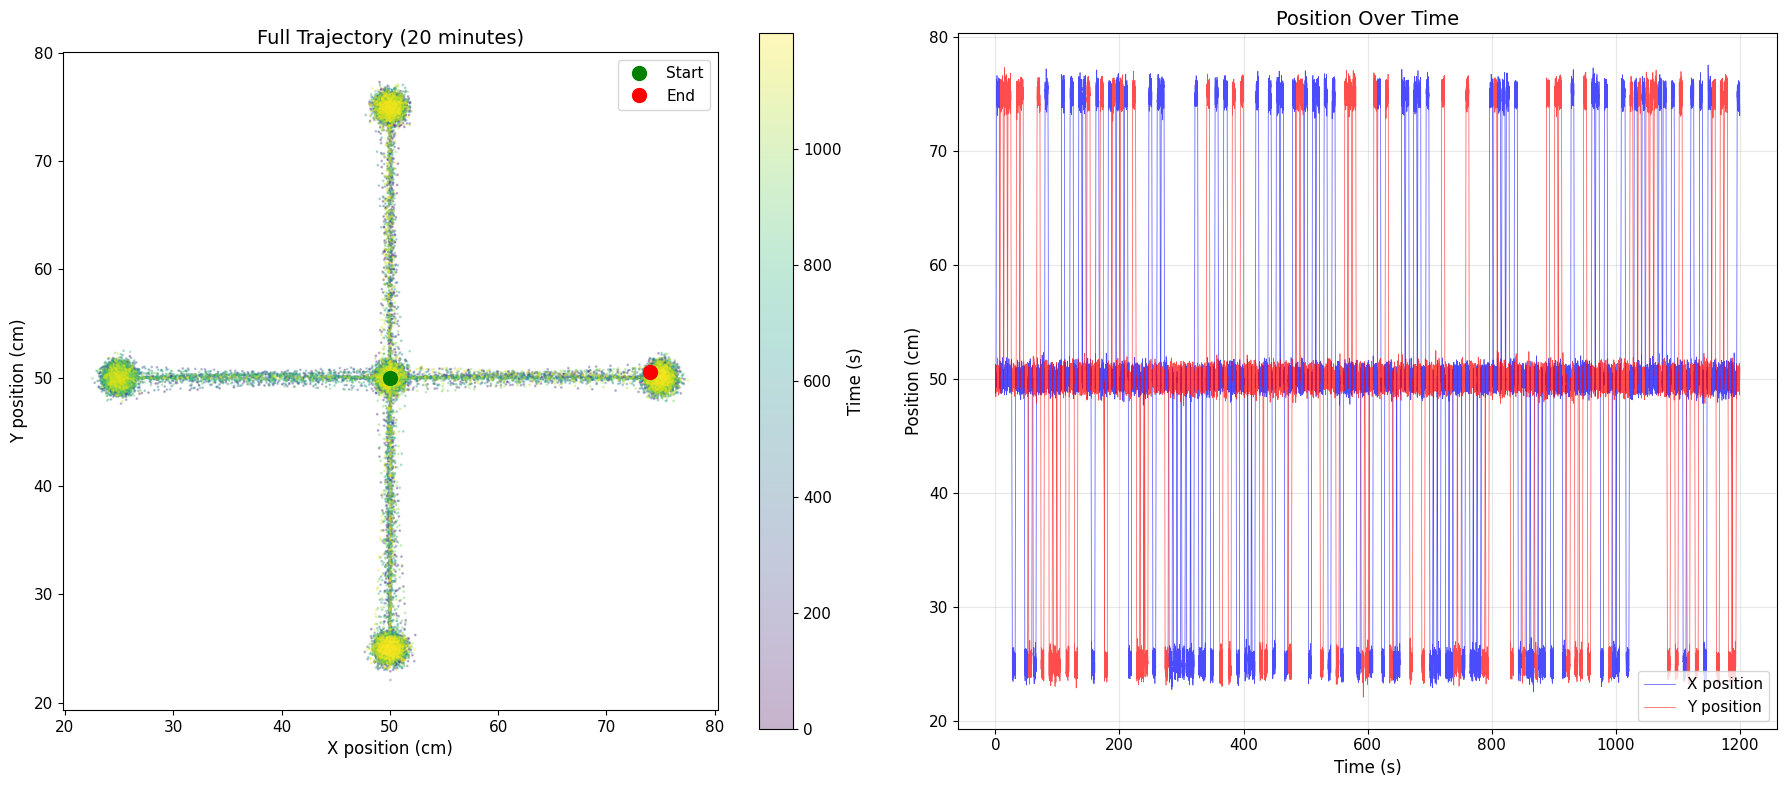

In [3]:
# Visualize trajectory
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Full trajectory colored by time
scatter = axes[0].scatter(
    position_data[:, 0],
    position_data[:, 1],
    c=timestamps,
    s=1,
    alpha=0.3,
    cmap="viridis",
)
axes[0].plot(
    position_data[0, 0], position_data[0, 1], "go", markersize=10, label="Start"
)
axes[0].plot(
    position_data[-1, 0], position_data[-1, 1], "ro", markersize=10, label="End"
)
axes[0].set_xlabel("X position (cm)")
axes[0].set_ylabel("Y position (cm)")
axes[0].set_title("Full Trajectory (20 minutes)")
axes[0].set_aspect("equal")
axes[0].legend()
plt.colorbar(scatter, ax=axes[0], label="Time (s)")

# Time series
axes[1].plot(
    timestamps, position_data[:, 0], "b-", alpha=0.7, linewidth=0.5, label="X position"
)
axes[1].plot(
    timestamps, position_data[:, 1], "r-", alpha=0.7, linewidth=0.5, label="Y position"
)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Position (cm)")
axes[1].set_title("Position Over Time")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 1.2 Simulate Neural Activity (Place Cells)

In [4]:
def generate_place_cell_spikes(position_data, timestamps, n_neurons=20):
    """
    Generate realistic place cell spike times.

    Parameters
    ----------
    position_data : ndarray, shape (n_samples, 2)
        Position trajectory.
    timestamps : ndarray, shape (n_samples,)
        Time for each position sample.
    n_neurons : int
        Number of neurons to simulate.

    Returns
    -------
    spike_times : dict
        Mapping from neuron_id to array of spike times.
    place_field_centers : dict
        Mapping from neuron_id to (x, y) place field center.
    """
    spike_times = {}
    place_field_centers = {}

    # Define regions for place fields
    regions = [
        (50, 75, "north"),  # North arm
        (50, 25, "south"),  # South arm
        (75, 50, "east"),  # East arm
        (25, 50, "west"),  # West arm
        (50, 50, "center"),  # Center
    ]

    for neuron_id in range(n_neurons):
        # Randomly assign place field
        if neuron_id < 15:  # 15 place cells
            # Choose region
            region = regions[neuron_id % len(regions)]
            # Add some variability
            center_x = region[0] + np.random.randn() * 5
            center_y = region[1] + np.random.randn() * 5
            place_field_centers[neuron_id] = (center_x, center_y)

            # Field width
            field_width = np.random.uniform(8, 15)

            # Peak firing rate
            peak_rate = np.random.uniform(8, 20)  # Hz

            # Calculate firing rate at each position
            distances = np.sqrt(
                (position_data[:, 0] - center_x) ** 2
                + (position_data[:, 1] - center_y) ** 2
            )
            firing_rates = peak_rate * np.exp(-(distances**2) / (2 * field_width**2))

        else:  # 5 non-spatial cells (control)
            place_field_centers[neuron_id] = None
            firing_rates = np.ones(len(timestamps)) * np.random.uniform(
                1, 3
            )  # Low baseline

        # Generate spikes from firing rates (inhomogeneous Poisson process)
        dt = np.diff(timestamps).mean()  # Time step
        spike_probs = firing_rates * dt  # Probability of spike in each time bin
        spike_occurred = np.random.rand(len(timestamps)) < spike_probs
        spike_times[neuron_id] = timestamps[spike_occurred]

    return spike_times, place_field_centers


# Generate spikes
spike_times, place_field_centers = generate_place_cell_spikes(position_data, timestamps)

print("\nNeural Activity Data:")
print(f"  Number of neurons: {len(spike_times)}")
print("  Place cells: 15")
print("  Non-spatial cells: 5")
print("\nSpike counts:")
for neuron_id in range(5):  # Show first 5
    n_spikes = len(spike_times[neuron_id])
    mean_rate = n_spikes / timestamps[-1]
    field_info = (
        ""
        if place_field_centers[neuron_id] is None
        else f" (field at {place_field_centers[neuron_id]})"
    )
    print(f"  Neuron {neuron_id}: {n_spikes} spikes, {mean_rate:.2f} Hz{field_info}")


Neural Activity Data:
  Number of neurons: 20
  Place cells: 15
  Non-spatial cells: 5

Spike counts:
  Neuron 0: 2550 spikes, 2.13 Hz (field at (52.905933068908794, 78.54288066686532))
  Neuron 1: 2386 spikes, 1.99 Hz (field at (44.61819029954033, 20.16027818946123))
  Neuron 2: 3614 spikes, 3.01 Hz (field at (80.18829096380401, 45.11910589089495))
  Neuron 3: 2546 spikes, 2.12 Hz (field at (25.183272204238953, 39.80059298300367))
  Neuron 4: 4132 spikes, 3.44 Hz (field at (47.51480131280007, 44.34407854469787))


## Step 2: Create Spatial Environment

Now we discretize the continuous position data into spatial bins.

In [5]:
# Create environment from position data
env = Environment.from_samples(
    data_samples=position_data,
    bin_size=3.0,  # 3 cm bins - good resolution for rodent place fields
    connect_diagonal_neighbors=True,
    infer_active_bins=True,
    bin_count_threshold=5,  # Require at least 5 samples per bin
    name="PlusMaze",
)

print("\nSpatial Environment:")
print(env.info())


Spatial Environment:
Environment Information

Name: PlusMaze
Layout Type: RegularGrid
Dimensions: 2
Number of Bins: 76

Spatial Extent:
  Dimension 0: [21.04, 79.03] (range: 57.99)
  Dimension 1: [20.59, 78.80] (range: 58.21)

Bin Sizes:
  Dimension 0: 2.90
  Dimension 1: 2.91

Regions: None



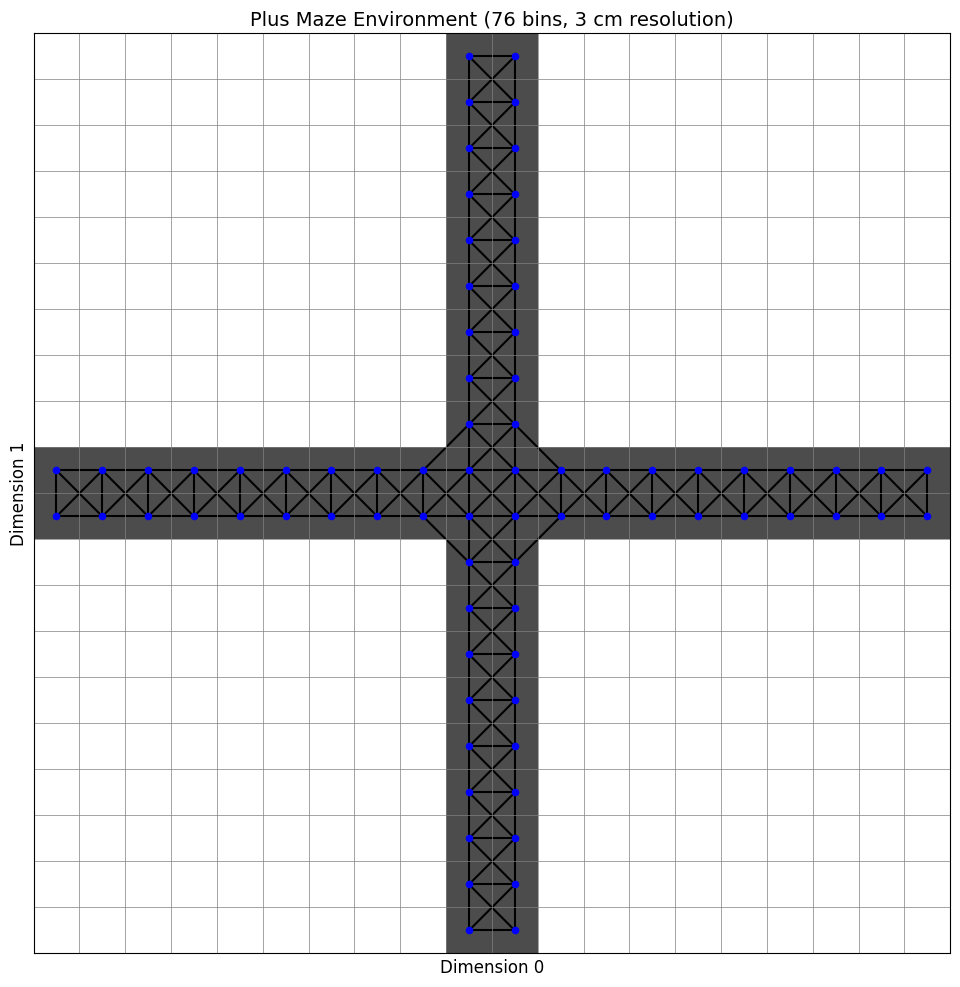

In [6]:
# Visualize the discretized environment
fig, ax = plt.subplots(figsize=(10, 10))
env.plot(ax=ax, show_connectivity=True)
ax.set_title(f"Plus Maze Environment ({env.n_bins} bins, 3 cm resolution)")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

### 2.1 Define Regions of Interest

In [7]:
# Add regions for each arm and center
regions_to_add = {
    "north_arm": (50, 75),
    "south_arm": (50, 25),
    "east_arm": (75, 50),
    "west_arm": (25, 50),
    "center": (50, 50),
    "north_reward": (50, 85),  # End of north arm
    "south_reward": (50, 15),  # End of south arm
}

for name, point in regions_to_add.items():
    env.regions.add(name=name, point=np.array(point))

print("Defined Regions:")
for name in env.regions:
    region = env.regions[name]
    print(f"  {name:15s}: {region.data}")

Defined Regions:
  north_arm      : [50. 75.]
  south_arm      : [50. 25.]
  east_arm       : [75. 50.]
  west_arm       : [25. 50.]
  center         : [50. 50.]
  north_reward   : [50. 85.]
  south_reward   : [50. 15.]


## Step 3: Compute Occupancy

Occupancy tells us how much time the animal spent in each bin. This is crucial for normalizing neural activity.

In [8]:
# Compute occupancy using the built-in method
# This automatically handles timestamp-to-bin mapping and time conversion
occupancy_time = env.occupancy(timestamps, position_data)

print("\nOccupancy Statistics:")
print(f"  Total time: {occupancy_time.sum():.1f} seconds")
print(f"  Mean time per bin: {occupancy_time[occupancy_time > 0].mean():.2f} seconds")
print(f"  Max time in any bin: {occupancy_time.max():.2f} seconds")
print(f"  Bins with >1 sec: {(occupancy_time > 1).sum()} / {env.n_bins}")

# Also get the bin sequence for later use in trajectory analysis
bin_indices = env.bin_at(position_data)


Occupancy Statistics:
  Total time: 1200.0 seconds
  Mean time per bin: 15.79 seconds
  Max time in any bin: 166.23 seconds
  Bins with >1 sec: 64 / 76


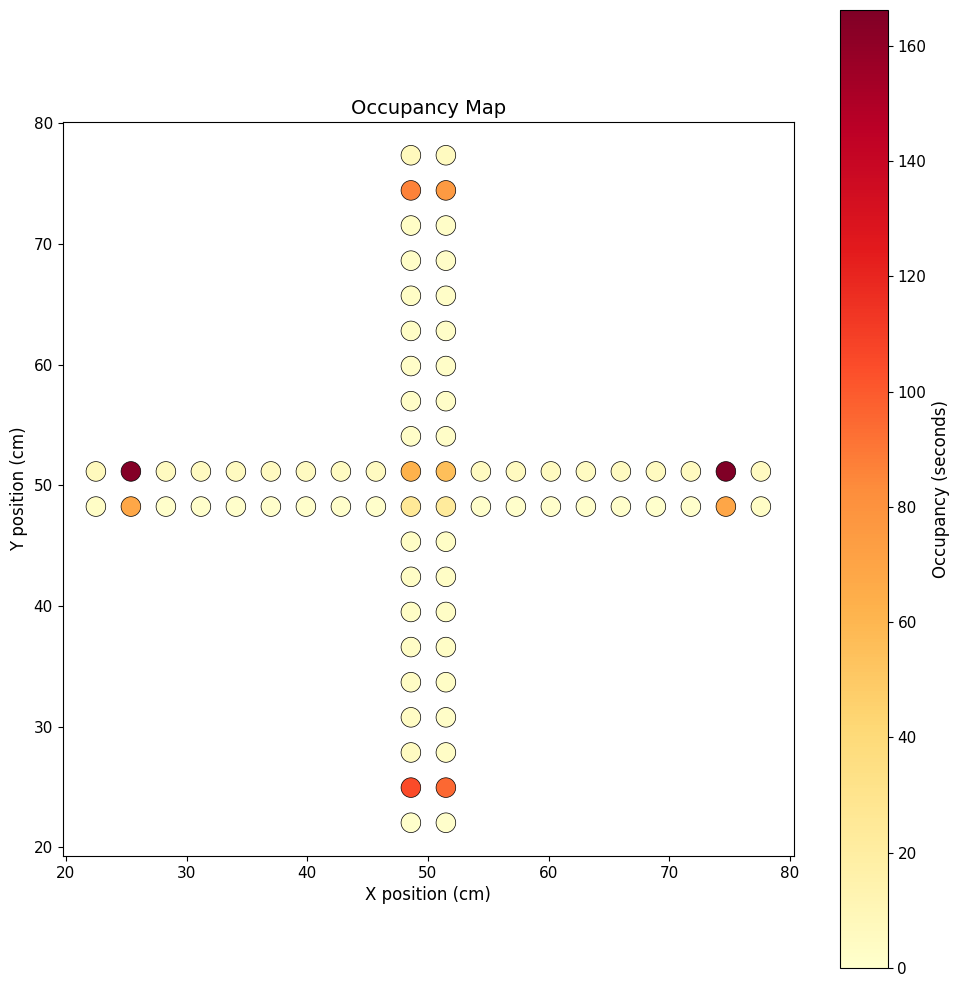

In [9]:
# Visualize occupancy
fig, ax = plt.subplots(figsize=(10, 10))

scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=occupancy_time,
    s=200,
    cmap="YlOrRd",
    vmin=0,
    edgecolors="black",
    linewidth=0.5,
)

plt.colorbar(scatter, ax=ax, label="Occupancy (seconds)")
ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title("Occupancy Map")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

## Step 4: Compute Place Fields (Firing Rate Maps)

For each neuron, we'll compute:
1. Spike count per bin
2. Occupancy-normalized firing rate (spikes/second)
3. Smoothed firing rate map

In [10]:
def compute_place_field(
    spike_times,
    position_data,
    bin_indices,
    timestamps,
    n_bins,
    occupancy_time,
    smooth_sigma=1.0,
):
    """
    Compute occupancy-normalized firing rate map.

    Parameters
    ----------
    spike_times : ndarray
        Spike times for one neuron.
    position_data : ndarray, shape (n_samples, 2)
        Position trajectory.
    bin_indices : ndarray, shape (n_samples,)
        Bin index for each position sample.
    timestamps : ndarray, shape (n_samples,)
        Time for each position sample.
    n_bins : int
        Total number of bins.
    occupancy_time : ndarray, shape (n_bins,)
        Time spent in each bin (seconds).
    smooth_sigma : float
        Gaussian smoothing parameter.

    Returns
    -------
    firing_rate : ndarray, shape (n_bins,)
        Firing rate in Hz for each bin.
    spike_count : ndarray, shape (n_bins,)
        Number of spikes in each bin.
    """
    # Find which bin the animal was in for each spike
    spike_bin_indices = np.zeros(len(spike_times), dtype=int)
    for i, spike_time in enumerate(spike_times):
        # Find closest timestamp
        idx = np.argmin(np.abs(timestamps - spike_time))
        spike_bin_indices[i] = bin_indices[idx]

    # Count spikes per bin
    spike_count = np.bincount(
        spike_bin_indices[spike_bin_indices >= 0], minlength=n_bins
    ).astype(float)

    # Compute firing rate (spikes / time)
    firing_rate = np.zeros(n_bins)
    valid_bins = occupancy_time > 0.1  # Only bins with >100ms occupancy
    firing_rate[valid_bins] = spike_count[valid_bins] / occupancy_time[valid_bins]

    return firing_rate, spike_count


# Compute place fields for all neurons
place_fields = {}
spike_counts = {}

print("Computing place fields...")
for neuron_id in range(len(spike_times)):
    firing_rate, spike_count = compute_place_field(
        spike_times=spike_times[neuron_id],
        position_data=position_data,
        bin_indices=bin_indices,
        timestamps=timestamps,
        n_bins=env.n_bins,
        occupancy_time=occupancy_time,
    )
    place_fields[neuron_id] = firing_rate
    spike_counts[neuron_id] = spike_count

print(f"\nComputed place fields for {len(place_fields)} neurons")
print("\nSample statistics (first 5 neurons):")
for neuron_id in range(5):
    mean_rate = place_fields[neuron_id][place_fields[neuron_id] > 0].mean()
    peak_rate = place_fields[neuron_id].max()
    print(f"  Neuron {neuron_id}: mean={mean_rate:.2f} Hz, peak={peak_rate:.2f} Hz")

Computing place fields...

Computed place fields for 20 neurons

Sample statistics (first 5 neurons):
  Neuron 0: mean=3.39 Hz, peak=13.55 Hz
  Neuron 1: mean=2.69 Hz, peak=10.43 Hz
  Neuron 2: mean=3.38 Hz, peak=15.87 Hz
  Neuron 3: mean=2.43 Hz, peak=8.16 Hz
  Neuron 4: mean=4.93 Hz, peak=13.45 Hz


### 4.1 Visualize Place Fields

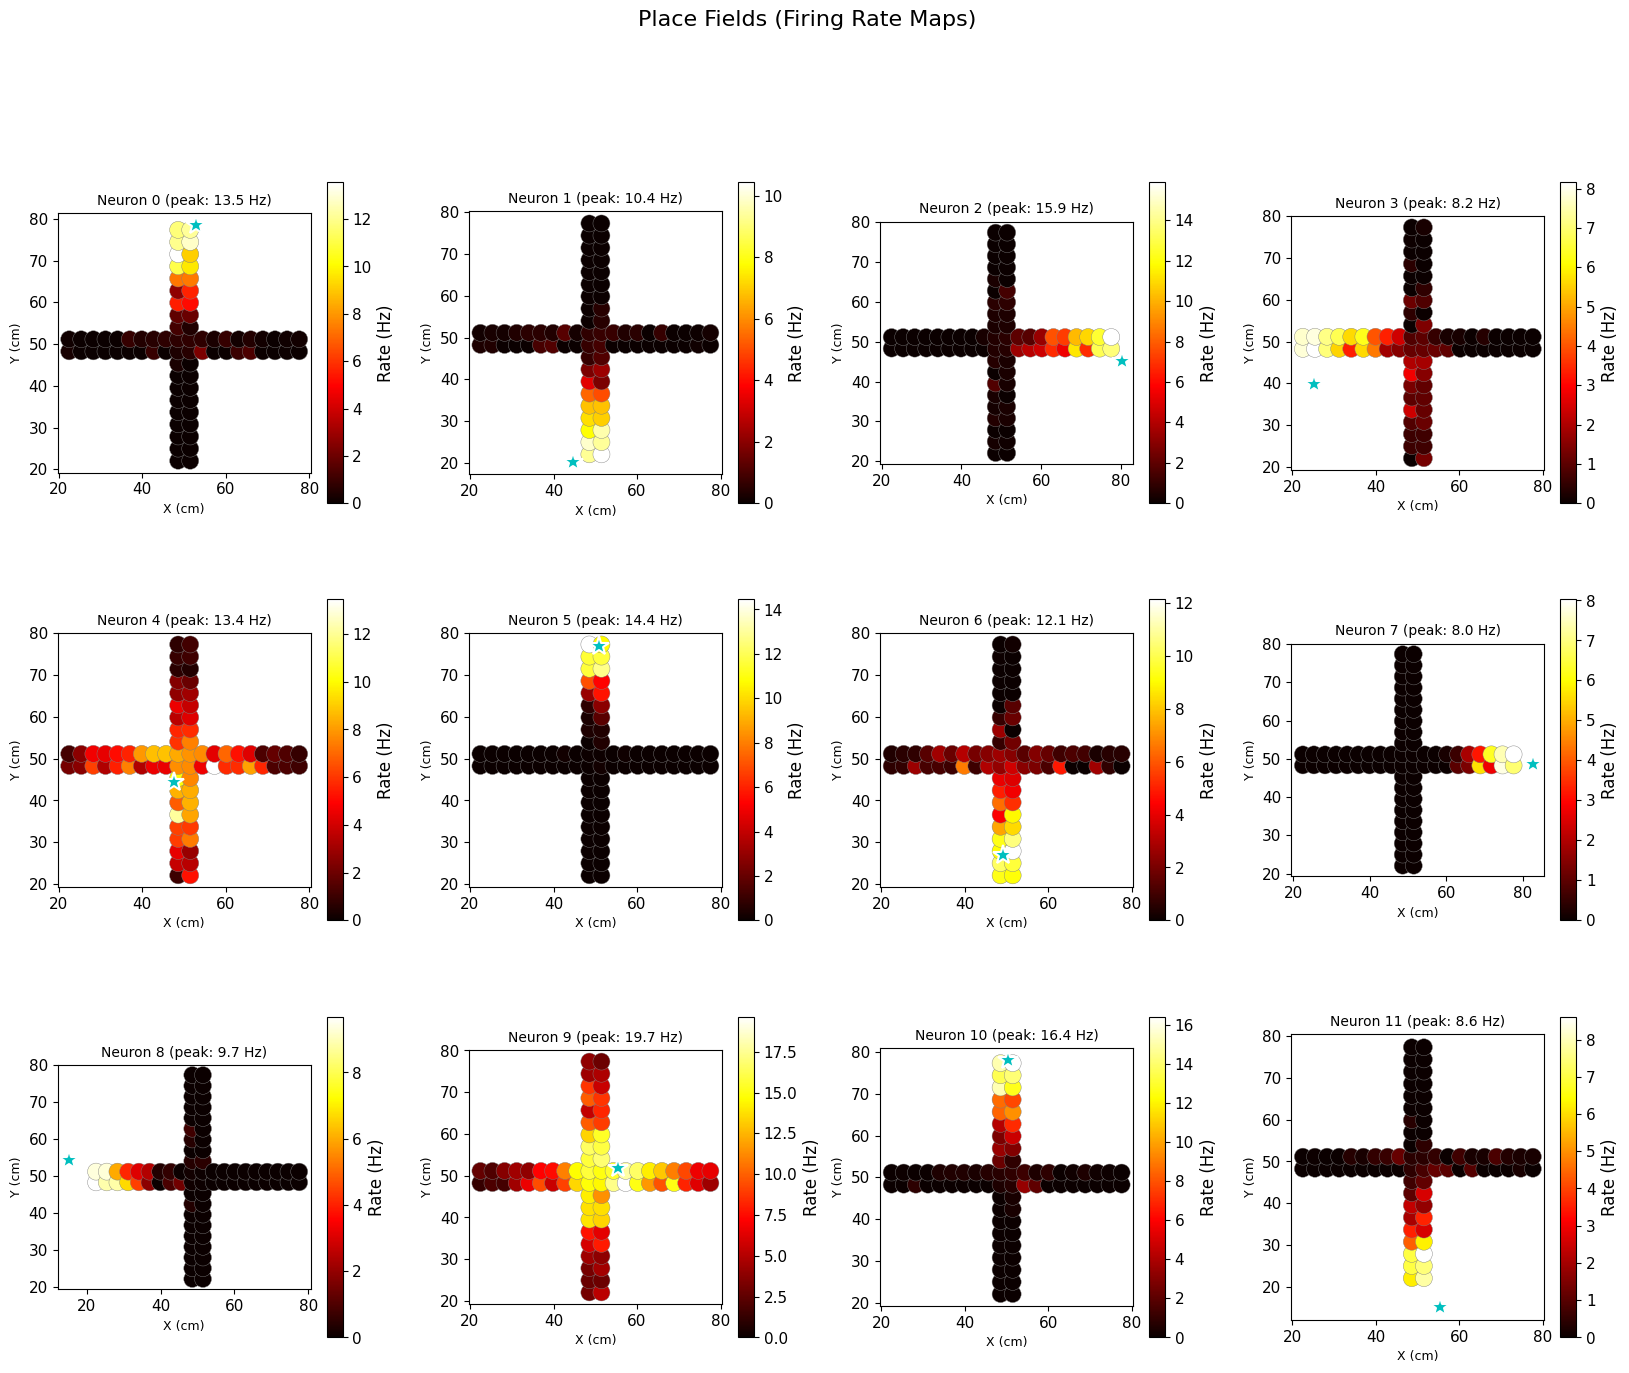

In [11]:
# Plot place fields for first 12 neurons
fig = plt.figure(figsize=(20, 15))
gs = GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)

for idx in range(12):
    ax = fig.add_subplot(gs[idx // 4, idx % 4])

    firing_rate = place_fields[idx]

    scatter = ax.scatter(
        env.bin_centers[:, 0],
        env.bin_centers[:, 1],
        c=firing_rate,
        s=150,
        cmap="hot",
        vmin=0,
        vmax=firing_rate.max() if firing_rate.max() > 0 else 1,
        edgecolors="gray",
        linewidth=0.3,
    )

    # Mark true place field center if it exists
    if place_field_centers[idx] is not None:
        ax.plot(
            place_field_centers[idx][0],
            place_field_centers[idx][1],
            "c*",
            markersize=15,
            markeredgecolor="white",
            markeredgewidth=1.5,
        )

    ax.set_xlabel("X (cm)", fontsize=9)
    ax.set_ylabel("Y (cm)", fontsize=9)
    ax.set_title(f"Neuron {idx} (peak: {firing_rate.max():.1f} Hz)", fontsize=10)
    ax.set_aspect("equal")
    plt.colorbar(scatter, ax=ax, label="Rate (Hz)")

plt.suptitle("Place Fields (Firing Rate Maps)", fontsize=16, y=0.995)
plt.show()

## Step 5: Spatial Information and Place Cell Detection

We'll compute spatial information (bits/spike) to quantify how well each neuron encodes spatial location.

In [12]:
def compute_spatial_information(firing_rate, occupancy_time):
    """
    Compute spatial information in bits per spike.

    Skaggs et al. (1993) metric:
    I = Σ p(x) * (r(x) / r_mean) * log2(r(x) / r_mean)

    Parameters
    ----------
    firing_rate : ndarray, shape (n_bins,)
        Firing rate in each bin (Hz).
    occupancy_time : ndarray, shape (n_bins,)
        Time spent in each bin (seconds).

    Returns
    -------
    spatial_info : float
        Spatial information in bits per spike.
    """
    # Occupancy probability
    total_time = occupancy_time.sum()
    p_x = occupancy_time / total_time

    # Mean firing rate
    r_mean = np.sum(firing_rate * p_x)

    if r_mean == 0:
        return 0.0

    # Spatial information
    spatial_info = 0.0
    for i in range(len(firing_rate)):
        if p_x[i] > 0 and firing_rate[i] > 0:
            spatial_info += (
                p_x[i] * (firing_rate[i] / r_mean) * np.log2(firing_rate[i] / r_mean)
            )

    return spatial_info


# Compute spatial information for all neurons
spatial_information = {}
for neuron_id in range(len(spike_times)):
    spatial_info = compute_spatial_information(
        firing_rate=place_fields[neuron_id], occupancy_time=occupancy_time
    )
    spatial_information[neuron_id] = spatial_info

# Sort by spatial information
sorted_neurons = sorted(spatial_information.items(), key=lambda x: x[1], reverse=True)

print("\nSpatial Information (bits/spike):")
print(f"{'Neuron':<10s} {'Info':>10s} {'Type':>15s} {'Peak Rate':>12s}")
print("-" * 50)
for neuron_id, info in sorted_neurons[:10]:  # Top 10
    cell_type = (
        "Place cell" if place_field_centers[neuron_id] is not None else "Non-spatial"
    )
    peak_rate = place_fields[neuron_id].max()
    print(f"{neuron_id:<10d} {info:>10.3f} {cell_type:>15s} {peak_rate:>10.2f} Hz")


Spatial Information (bits/spike):
Neuron           Info            Type    Peak Rate
--------------------------------------------------
5               2.567      Place cell      14.45 Hz
7               2.197      Place cell       8.02 Hz
0               2.141      Place cell      13.55 Hz
10              2.140      Place cell      16.44 Hz
13              2.109      Place cell      12.22 Hz
8               2.091      Place cell       9.69 Hz
12              1.868      Place cell      16.88 Hz
11              1.802      Place cell       8.62 Hz
1               1.790      Place cell      10.43 Hz
2               1.776      Place cell      15.87 Hz


In [13]:
# Classify place cells using threshold
place_cell_threshold = 0.5  # bits/spike (common threshold)

place_cell_ids = [
    nid for nid, info in spatial_information.items() if info > place_cell_threshold
]
non_spatial_ids = [
    nid for nid, info in spatial_information.items() if info <= place_cell_threshold
]

print(f"\nPlace Cell Classification (threshold = {place_cell_threshold} bits/spike):")
print(f"  Place cells: {len(place_cell_ids)} / {len(spike_times)}")
print(f"  Non-spatial: {len(non_spatial_ids)} / {len(spike_times)}")

# Compare with ground truth
true_place_cells = list(range(15))  # We know first 15 are place cells
true_positives = len(set(place_cell_ids) & set(true_place_cells))
false_positives = len(set(place_cell_ids) - set(true_place_cells))
false_negatives = len(set(true_place_cells) - set(place_cell_ids))

precision = true_positives / len(place_cell_ids) if place_cell_ids else 0
recall = true_positives / len(true_place_cells)

print("\nDetection Performance (vs ground truth):")
print(f"  True positives: {true_positives}")
print(f"  False positives: {false_positives}")
print(f"  False negatives: {false_negatives}")
print(f"  Precision: {precision:.2%}")
print(f"  Recall: {recall:.2%}")


Place Cell Classification (threshold = 0.5 bits/spike):
  Place cells: 13 / 20
  Non-spatial: 7 / 20

Detection Performance (vs ground truth):
  True positives: 13
  False positives: 0
  False negatives: 2
  Precision: 100.00%
  Recall: 86.67%


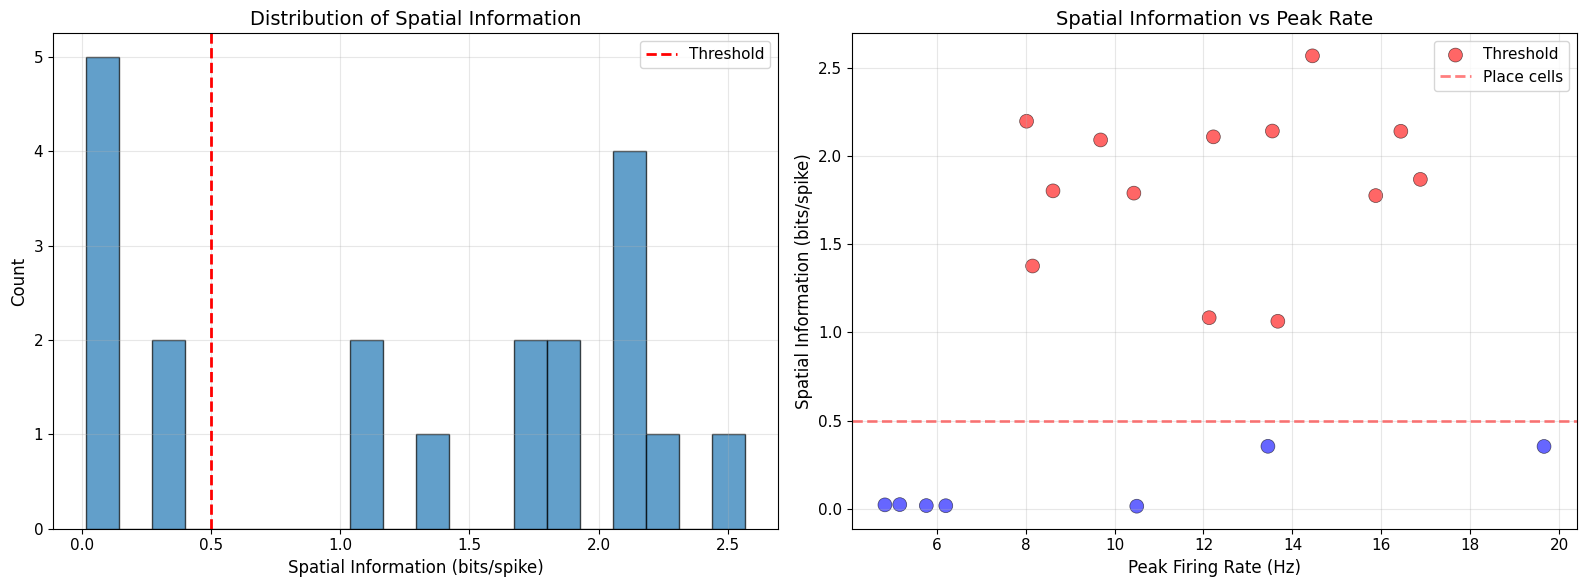

In [14]:
# Visualize spatial information distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
info_values = list(spatial_information.values())
axes[0].hist(info_values, bins=20, alpha=0.7, edgecolor="black")
axes[0].axvline(
    place_cell_threshold, color="red", linestyle="--", linewidth=2, label="Threshold"
)
axes[0].set_xlabel("Spatial Information (bits/spike)")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Spatial Information")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter: spatial info vs peak rate
peak_rates = [place_fields[nid].max() for nid in range(len(spike_times))]
colors = ["red" if nid in place_cell_ids else "blue" for nid in range(len(spike_times))]
axes[1].scatter(
    peak_rates,
    info_values,
    c=colors,
    s=100,
    alpha=0.6,
    edgecolors="black",
    linewidth=0.5,
)
axes[1].axhline(
    place_cell_threshold, color="red", linestyle="--", linewidth=2, alpha=0.5
)
axes[1].set_xlabel("Peak Firing Rate (Hz)")
axes[1].set_ylabel("Spatial Information (bits/spike)")
axes[1].set_title("Spatial Information vs Peak Rate")
axes[1].grid(True, alpha=0.3)
axes[1].legend(["Threshold", "Place cells", "Non-spatial"], loc="upper right")

plt.tight_layout()
plt.show()

## Step 6: Multi-Region Analysis

Analyze how neurons respond differently in different maze compartments.

In [15]:
def compute_region_firing_rates(
    spike_times, bin_indices, timestamps, env, region_names
):
    """
    Compute mean firing rate in each region for each neuron.

    Parameters
    ----------
    spike_times : dict
        Spike times for all neurons.
    bin_indices : ndarray
        Bin index for each timestamp.
    timestamps : ndarray
        Time for each position sample.
    env : Environment
        Spatial environment.
    region_names : list of str
        Names of regions to analyze.

    Returns
    -------
    region_rates : dict
        Nested dict: {neuron_id: {region_name: firing_rate}}.
    """
    region_rates = {nid: {} for nid in spike_times}

    for region_name in region_names:
        # Find bins in this region (within 10 cm of region point)
        region_point = env.regions[region_name].data
        distances_to_region = np.linalg.norm(env.bin_centers - region_point, axis=1)
        region_bin_mask = distances_to_region < 10.0  # Within 10 cm
        region_bins = np.where(region_bin_mask)[0]

        # Find times when animal was in this region
        in_region = np.isin(bin_indices, region_bins)
        region_duration = in_region.sum() / 30.0  # seconds

        if region_duration < 1.0:  # Skip if less than 1 second
            for nid in spike_times:
                region_rates[nid][region_name] = np.nan
            continue

        # Count spikes in region for each neuron
        for nid, spikes in spike_times.items():
            # Find which spikes occurred in region
            spike_in_region = np.zeros(len(spikes), dtype=bool)
            for i, spike_time in enumerate(spikes):
                idx = np.argmin(np.abs(timestamps - spike_time))
                spike_in_region[i] = in_region[idx]

            n_spikes = spike_in_region.sum()
            region_rates[nid][region_name] = n_spikes / region_duration

    return region_rates


# Compute firing rates in each arm
arm_names = ["north_arm", "south_arm", "east_arm", "west_arm", "center"]
region_rates = compute_region_firing_rates(
    spike_times=spike_times,
    bin_indices=bin_indices,
    timestamps=timestamps,
    env=env,
    region_names=arm_names,
)

print("\nRegion-Specific Firing Rates:")
print(f"\n{'Neuron':<10s}", end="")
for region_name in arm_names:
    print(f"{region_name:>12s}", end="")
print()
print("-" * 70)

for neuron_id in range(5):  # Show first 5
    print(f"{neuron_id:<10d}", end="")
    for region_name in arm_names:
        rate = region_rates[neuron_id][region_name]
        if np.isnan(rate):
            print(f"{'N/A':>12s}", end="")
        else:
            print(f"{rate:>10.2f} Hz", end="")
    print()


Region-Specific Firing Rates:

Neuron       north_arm   south_arm    east_arm    west_arm      center
----------------------------------------------------------------------
0              12.13 Hz      0.00 Hz      0.12 Hz      0.03 Hz      0.77 Hz
1               0.00 Hz      9.45 Hz      0.08 Hz      0.26 Hz      0.67 Hz
2               0.04 Hz      0.23 Hz     12.60 Hz      0.00 Hz      0.70 Hz
3               0.04 Hz      0.68 Hz      0.01 Hz      7.83 Hz      1.09 Hz
4               1.05 Hz      3.79 Hz      1.48 Hz      2.71 Hz      7.78 Hz


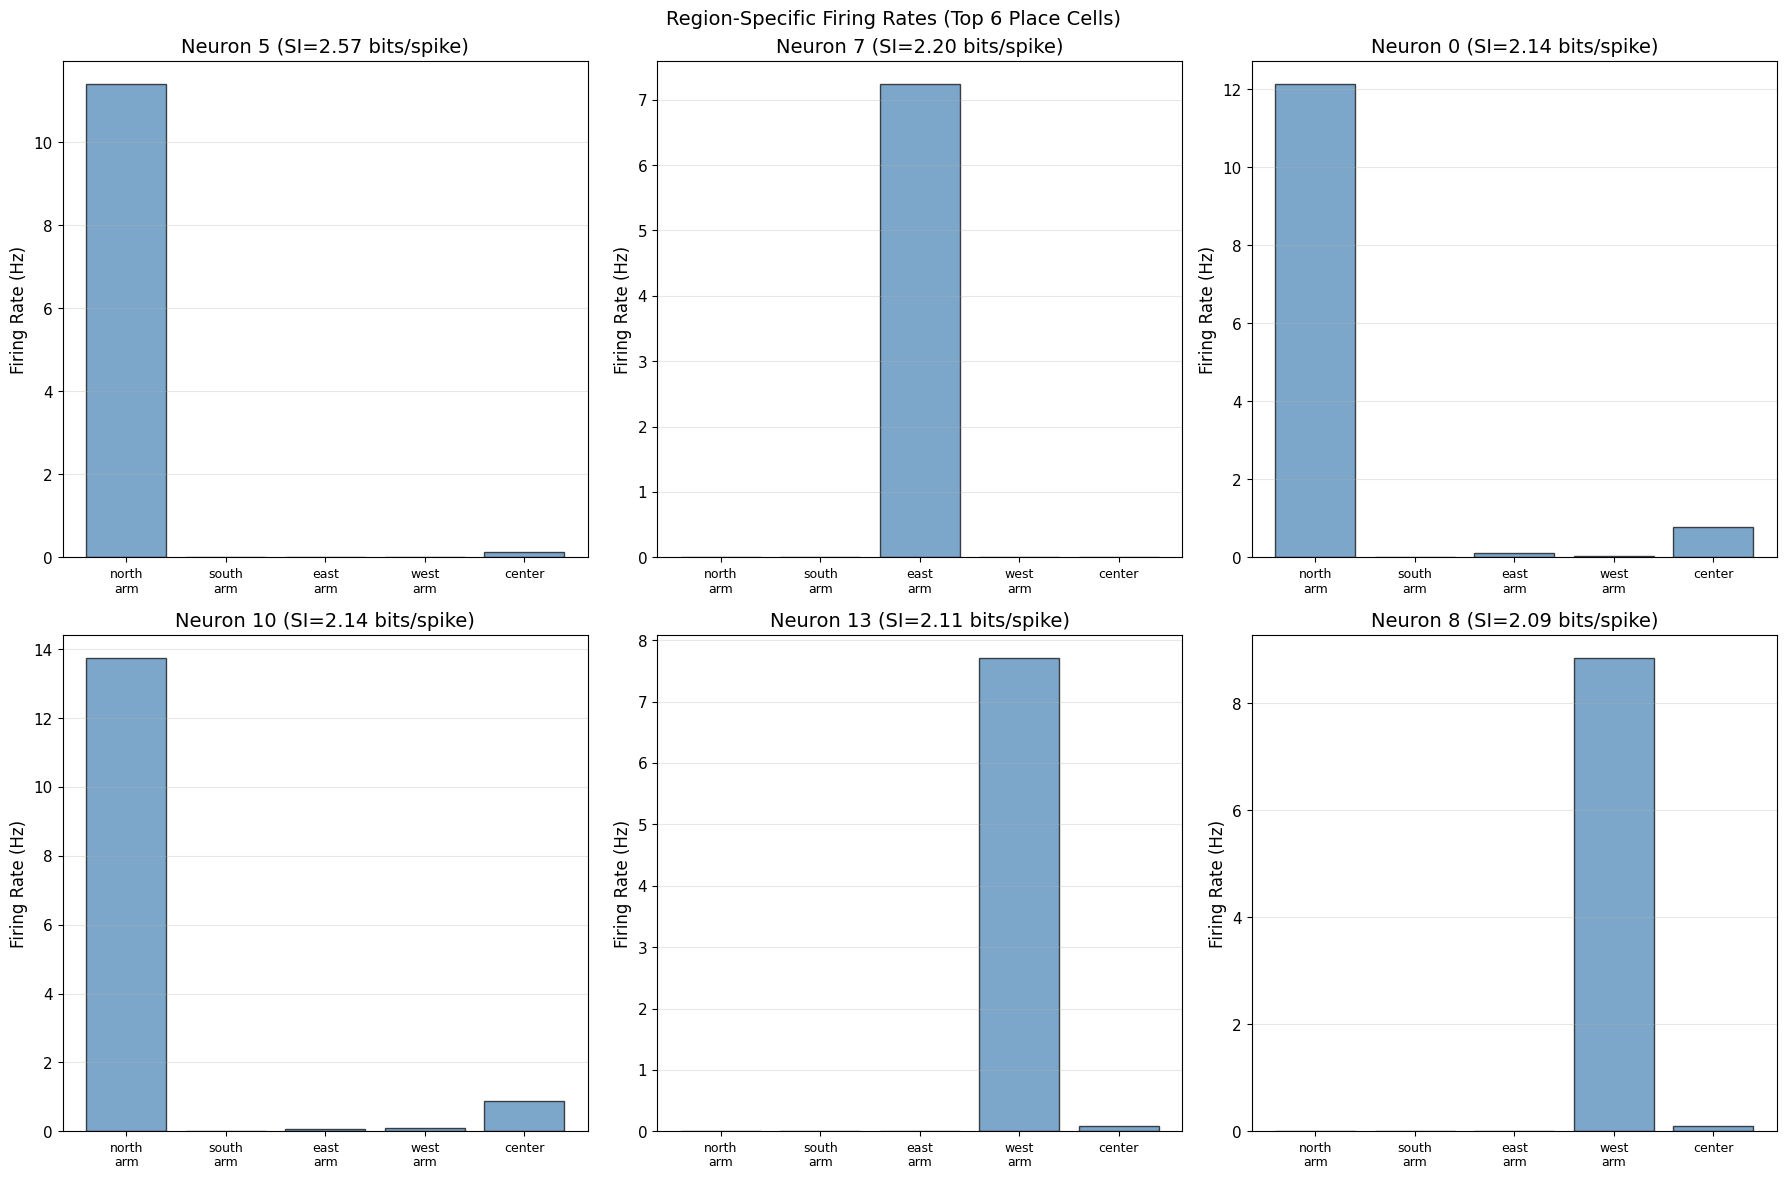

In [16]:
# Visualize region selectivity for place cells
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Show first 6 place cells
for idx, neuron_id in enumerate(sorted_neurons[:6]):
    neuron_id = neuron_id[0]  # Extract ID from tuple

    rates = [region_rates[neuron_id][name] for name in arm_names]
    rates = [0 if np.isnan(r) else r for r in rates]  # Replace NaN with 0

    axes[idx].bar(
        range(len(arm_names)), rates, color="steelblue", edgecolor="black", alpha=0.7
    )
    axes[idx].set_xticks(range(len(arm_names)))
    axes[idx].set_xticklabels(
        [name.replace("_", "\n") for name in arm_names], fontsize=9
    )
    axes[idx].set_ylabel("Firing Rate (Hz)")
    axes[idx].set_title(
        f"Neuron {neuron_id} (SI={spatial_information[neuron_id]:.2f} bits/spike)"
    )
    axes[idx].grid(True, alpha=0.3, axis="y")

plt.suptitle("Region-Specific Firing Rates (Top 6 Place Cells)", fontsize=14)
plt.tight_layout()
plt.show()

## Step 8: Population Analysis

Analyze the entire population of place cells to understand ensemble coding.

In [17]:
# Create population rate matrix (neurons × bins)
n_place_cells = len(place_cell_ids)
population_matrix = np.zeros((n_place_cells, env.n_bins))

for i, neuron_id in enumerate(place_cell_ids):
    population_matrix[i, :] = place_fields[neuron_id]

print(f"\nPopulation Matrix Shape: {population_matrix.shape}")
print(f"  Neurons: {n_place_cells}")
print(f"  Bins: {env.n_bins}")


Population Matrix Shape: (13, 76)
  Neurons: 13
  Bins: 76


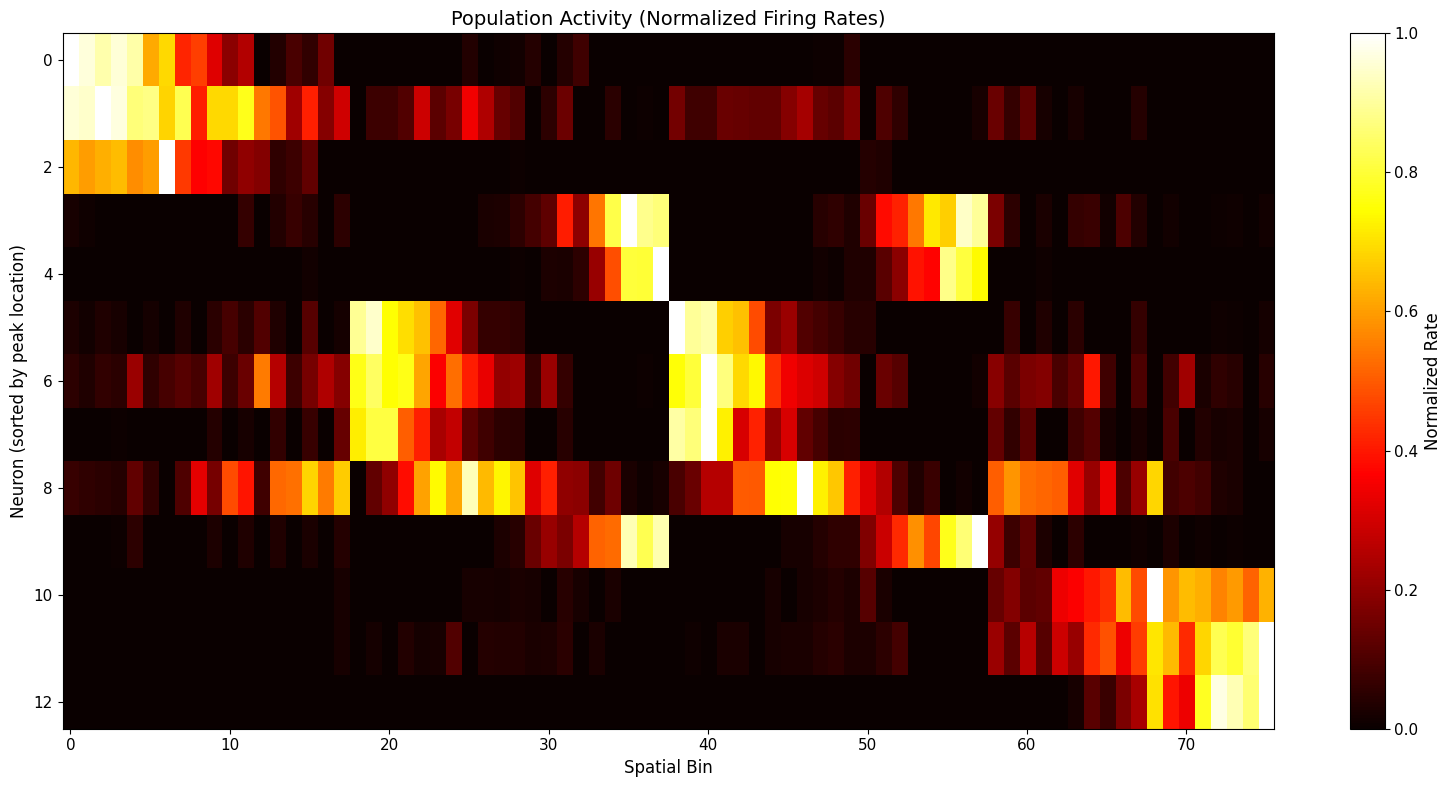

In [18]:
# Visualize population activity as heatmap
fig, ax = plt.subplots(figsize=(16, 8))

# Sort neurons by peak location
peak_bins = [place_fields[nid].argmax() for nid in place_cell_ids]
sort_order = np.argsort(peak_bins)

# Normalize each neuron's activity to [0, 1]
population_normalized = population_matrix.copy()
for i in range(n_place_cells):
    max_rate = population_normalized[i, :].max()
    if max_rate > 0:
        population_normalized[i, :] /= max_rate

im = ax.imshow(
    population_normalized[sort_order, :],
    aspect="auto",
    cmap="hot",
    interpolation="nearest",
)

ax.set_xlabel("Spatial Bin")
ax.set_ylabel("Neuron (sorted by peak location)")
ax.set_title("Population Activity (Normalized Firing Rates)")
plt.colorbar(im, ax=ax, label="Normalized Rate")
plt.tight_layout()
plt.show()

### 7.1 Compute Population Vector Correlations

How similar is the population activity pattern in different locations?

In [19]:
# Compute correlation matrix between all pairs of bins
# (how similar is the population code at different locations?)
n_bins = env.n_bins
correlation_matrix = np.zeros((n_bins, n_bins))

for i in range(n_bins):
    for j in range(i, n_bins):
        # Population vectors at bins i and j
        vec_i = population_matrix[:, i]
        vec_j = population_matrix[:, j]

        # Compute correlation (if both have activity)
        if vec_i.sum() > 0 and vec_j.sum() > 0:
            corr, _ = pearsonr(vec_i, vec_j)
            correlation_matrix[i, j] = corr
            correlation_matrix[j, i] = corr
        else:
            correlation_matrix[i, j] = 0
            correlation_matrix[j, i] = 0

print(f"Population Vector Correlation Matrix: {correlation_matrix.shape}")
print(f"Mean correlation: {correlation_matrix[correlation_matrix > 0].mean():.3f}")
print(f"Max correlation: {correlation_matrix.max():.3f}")

Population Vector Correlation Matrix: (76, 76)
Mean correlation: 0.568
Max correlation: 1.000


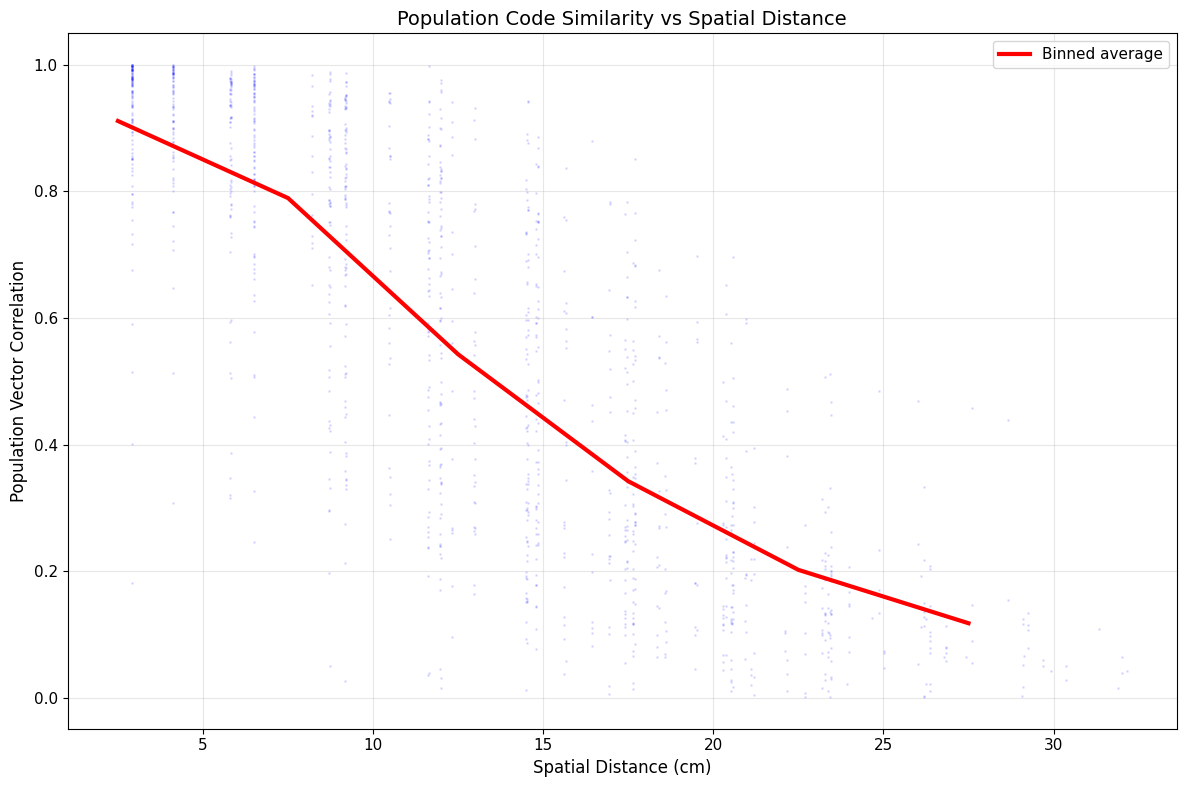


Interpretation: Higher correlation at short distances means nearby
locations have similar population activity patterns (smooth representation).


In [20]:
# Visualize correlation as a function of spatial distance
# Do nearby locations have more similar population codes?
spatial_distances = []
correlations = []

for i in range(n_bins):
    for j in range(i + 1, n_bins):
        # Spatial distance
        dist = np.linalg.norm(env.bin_centers[i] - env.bin_centers[j])
        corr = correlation_matrix[i, j]

        if corr > 0:  # Only valid correlations
            spatial_distances.append(dist)
            correlations.append(corr)

spatial_distances = np.array(spatial_distances)
correlations = np.array(correlations)

# Plot
fig, ax = plt.subplots(figsize=(12, 8))

# Scatter with transparency
ax.scatter(spatial_distances, correlations, s=1, alpha=0.1, c="blue")

# Binned average
bins = np.arange(0, spatial_distances.max(), 5)
bin_indices = np.digitize(spatial_distances, bins)
binned_corr = [correlations[bin_indices == i].mean() for i in range(1, len(bins))]
bin_centers = bins[:-1] + np.diff(bins) / 2
ax.plot(bin_centers, binned_corr, "r-", linewidth=3, label="Binned average")

ax.set_xlabel("Spatial Distance (cm)")
ax.set_ylabel("Population Vector Correlation")
ax.set_title("Population Code Similarity vs Spatial Distance")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInterpretation: Higher correlation at short distances means nearby")
print("locations have similar population activity patterns (smooth representation).")

## Step 7: Movement and Navigation Analysis

Beyond static firing rate maps, we can analyze behavioral structure and navigation patterns:

- **Movement patterns**: How does the animal traverse the environment? Are paths stereotyped or exploratory?
- **Navigation behavior**: Is movement goal-directed or random?
- **Distance-dependent activity**: Do neurons encode proximity to rewards or landmarks?

These analyses reveal behavioral structure that complements spatial tuning and are essential for understanding navigation strategies.

### 7.1 Transition Matrix Analysis

In [ ]:
# Compute transition matrix using the built-in method
# This counts how often the animal moves from one bin to another
transitions_raw = env.transitions(
    times=timestamps, positions=position_data, normalize=False
)
transitions_prob = env.transitions(
    times=timestamps, positions=position_data, normalize=True
)

print("\nTransition Matrix:")
print(f"  Shape: {transitions_raw.shape}")
print(f"  Total transitions: {transitions_raw.nnz}")
print(f"  Sparsity: {100 * (1 - transitions_raw.nnz / (env.n_bins**2)):.1f}%")

# Find most common transitions
transitions_dense = transitions_prob.toarray()
max_prob = np.max(transitions_dense)
max_idx = np.unravel_index(np.argmax(transitions_dense), transitions_dense.shape)
print("\nMost common transition:")
print(f"  Bin {max_idx[0]} → Bin {max_idx[1]}")
print(f"  Probability: {max_prob:.3f}")
print(f"  Position: {env.bin_centers[max_idx[0]]} → {env.bin_centers[max_idx[1]]}")

In [ ]:
# Visualize transition matrix
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Raw counts
im1 = axes[0].imshow(
    transitions_raw.toarray(), cmap="hot", interpolation="nearest", aspect="auto"
)
axes[0].set_xlabel("To Bin")
axes[0].set_ylabel("From Bin")
axes[0].set_title("Transition Counts")
plt.colorbar(im1, ax=axes[0], label="Count")

# Normalized probabilities
im2 = axes[1].imshow(
    transitions_dense,
    cmap="hot",
    interpolation="nearest",
    aspect="auto",
    vmin=0,
    vmax=0.5,
)
axes[1].set_xlabel("To Bin")
axes[1].set_ylabel("From Bin")
axes[1].set_title("Transition Probabilities")
plt.colorbar(im2, ax=axes[1], label="Probability")

plt.tight_layout()
plt.show()

In [ ]:
# Compute transition entropy (measure of movement randomness)
def compute_transition_entropy(T_normalized):
    """Shannon entropy of transition probabilities for each bin."""
    T_dense = T_normalized.toarray()
    entropy = np.zeros(env.n_bins)

    for i in range(env.n_bins):
        row = T_dense[i]
        p = row[row > 0]  # Only non-zero probabilities
        if len(p) > 0:
            entropy[i] = -np.sum(p * np.log2(p))

    return entropy


transition_entropy = compute_transition_entropy(transitions_prob)

print("\nTransition Entropy:")
print(f"  Mean: {transition_entropy[transition_entropy > 0].mean():.2f} bits")
print(f"  Max: {transition_entropy.max():.2f} bits (most random movement)")
print(
    f"  Min: {transition_entropy[transition_entropy > 0].min():.2f} bits (most stereotyped)"
)

# Visualize entropy
fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=transition_entropy,
    s=200,
    cmap="viridis",
    edgecolors="black",
    linewidth=0.5,
)
plt.colorbar(scatter, ax=ax, label="Transition Entropy (bits)")
ax.set_xlabel("X position (cm)")
ax.set_ylabel("Y position (cm)")
ax.set_title(
    "Movement Randomness\n(High = many transition options, Low = stereotyped paths)"
)
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

### 7.2 Bin Sequence and Run Analysis

In [ ]:
# Get the temporal sequence of bins visited
# This is useful for detecting runs (consecutive time in same location)
bin_sequence = env.bin_sequence(timestamps, position_data)

print("\nBin Sequence Analysis:")
print(f"  Total samples: {len(position_data)}")
print(f"  Valid bin assignments: {len(bin_sequence)}")
print(f"  First 20 bins visited: {bin_sequence[:20]}")

# Detect runs (consecutive samples in same bin)
run_changes = np.where(np.diff(bin_sequence) != 0)[0] + 1
run_starts = np.concatenate([[0], run_changes])
run_ends = np.concatenate([run_changes, [len(bin_sequence)]])

run_bins = bin_sequence[run_starts]
run_durations_samples = run_ends - run_starts
run_durations_time = run_durations_samples / 30.0  # Convert to seconds

print("\nRun Statistics:")
print(f"  Total runs: {len(run_starts)}")
print(f"  Mean run duration: {run_durations_time.mean():.2f} seconds")
print(f"  Median run duration: {np.median(run_durations_time):.2f} seconds")
print(f"  Longest run: {run_durations_time.max():.2f} seconds")

# Find longest run
longest_idx = np.argmax(run_durations_time)
longest_bin = run_bins[longest_idx]
print("\nLongest run:")
print(f"  Bin: {longest_bin}")
print(f"  Position: {env.bin_centers[longest_bin]}")
print(f"  Duration: {run_durations_time[longest_idx]:.2f} seconds")

In [ ]:
# Visualize run duration distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of run durations
axes[0].hist(run_durations_time, bins=50, edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Run Duration (seconds)")
axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Run Durations")
axes[0].axvline(
    run_durations_time.mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean = {run_durations_time.mean():.2f}s",
)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis="y")

# Mean run duration per bin
mean_duration_per_bin = np.zeros(env.n_bins)
for bin_idx in range(env.n_bins):
    bin_runs = run_durations_time[run_bins == bin_idx]
    if len(bin_runs) > 0:
        mean_duration_per_bin[bin_idx] = bin_runs.mean()

scatter = axes[1].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=mean_duration_per_bin,
    s=200,
    cmap="plasma",
    edgecolors="black",
    linewidth=0.5,
    vmin=0,
)
plt.colorbar(scatter, ax=axes[1], label="Mean Run Duration (s)")
axes[1].set_xlabel("X position (cm)")
axes[1].set_ylabel("Y position (cm)")
axes[1].set_title("Average Time Spent Per Visit")
axes[1].set_aspect("equal")

plt.tight_layout()
plt.show()

### 7.3 Distance Fields for Navigation Analysis

In [ ]:
# Compute geodesic distance from reward locations
# This is useful for analyzing goal-directed behavior

# North reward location
north_reward = env.regions["north_reward"].data
north_reward_bin = env.bin_at(north_reward.reshape(1, -1))[0]

# Compute distance field using the built-in method
# distance_to() requires targets as a sequence (list, tuple, or array)
distances_to_north = env.distance_to([north_reward_bin], metric="geodesic")

# Also compute Euclidean for comparison
distances_euclidean = env.distance_to([north_reward_bin], metric="euclidean")

print("\nDistance Field Analysis:")
print(f"  North reward bin: {north_reward_bin}")
print(f"  North reward position: {north_reward}")
print("\nGeodesic distances:")
print(f"  Mean: {distances_to_north[np.isfinite(distances_to_north)].mean():.2f} cm")
print(f"  Max: {distances_to_north[np.isfinite(distances_to_north)].max():.2f} cm")
print("\nEuclidean distances:")
print(f"  Mean: {distances_euclidean.mean():.2f} cm")
print(f"  Max: {distances_euclidean.max():.2f} cm")

# Compute ratio (measures path complexity)
ratio = distances_to_north / distances_euclidean
print("\nGeodesic/Euclidean ratio:")
print(f"  Mean: {ratio[np.isfinite(ratio)].mean():.2f}")
print(f"  Max: {ratio[np.isfinite(ratio)].max():.2f}")

In [ ]:
# Visualize distance fields
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Euclidean distance
scatter1 = axes[0].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=distances_euclidean,
    s=150,
    cmap="viridis",
    edgecolors="black",
    linewidth=0.3,
)
axes[0].scatter(
    *north_reward,
    c="red",
    s=400,
    marker="*",
    edgecolors="white",
    linewidth=2,
    label="North Reward",
    zorder=10,
)
axes[0].set_xlabel("X position (cm)")
axes[0].set_ylabel("Y position (cm)")
axes[0].set_title("Euclidean Distance to Reward")
axes[0].set_aspect("equal")
axes[0].legend()
plt.colorbar(scatter1, ax=axes[0], label="Distance (cm)")

# Geodesic distance
scatter2 = axes[1].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=distances_to_north,
    s=150,
    cmap="viridis",
    edgecolors="black",
    linewidth=0.3,
)
axes[1].scatter(
    *north_reward,
    c="red",
    s=400,
    marker="*",
    edgecolors="white",
    linewidth=2,
    label="North Reward",
    zorder=10,
)
axes[1].set_xlabel("X position (cm)")
axes[1].set_ylabel("Y position (cm)")
axes[1].set_title("Geodesic Distance to Reward\n(Through Environment)")
axes[1].set_aspect("equal")
axes[1].legend()
plt.colorbar(scatter2, ax=axes[1], label="Distance (cm)")

# Ratio (path complexity)
scatter3 = axes[2].scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=ratio,
    s=150,
    cmap="RdYlGn_r",
    edgecolors="black",
    linewidth=0.3,
    vmin=1.0,
    vmax=2.0,
)
axes[2].scatter(
    *north_reward,
    c="red",
    s=400,
    marker="*",
    edgecolors="white",
    linewidth=2,
    label="North Reward",
    zorder=10,
)
axes[2].set_xlabel("X position (cm)")
axes[2].set_ylabel("Y position (cm)")
axes[2].set_title("Path Complexity\n(Geodesic/Euclidean Ratio)")
axes[2].set_aspect("equal")
axes[2].legend()
plt.colorbar(scatter3, ax=axes[2], label="Ratio")

plt.tight_layout()
plt.show()

print("\nInterpretation: Higher ratio means the animal must take a longer path")
print("through the environment to reach the goal (e.g., around barriers).")

### 7.5.4 Analyzing Neural Activity with Distance Fields

In [ ]:
# Analyze how place cell activity relates to distance from reward
# Do neurons fire more when approaching the reward?

# Pick a place cell with field near north arm
best_neuron = sorted_neurons[0][0]  # Highest spatial information
neuron_firing_rate = place_fields[best_neuron]

# Bin distance field into ranges
distance_bins = [0, 20, 40, 60, 100]
distance_labels = ["0-20 cm", "20-40 cm", "40-60 cm", ">60 cm"]

mean_rate_by_distance = []
for i in range(len(distance_bins) - 1):
    mask = (distances_to_north >= distance_bins[i]) & (
        distances_to_north < distance_bins[i + 1]
    )
    if mask.any():
        rates_in_range = neuron_firing_rate[mask]
        mean_rate_by_distance.append(
            rates_in_range[rates_in_range > 0].mean()
            if (rates_in_range > 0).any()
            else 0
        )
    else:
        mean_rate_by_distance.append(0)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(
    range(len(distance_labels)),
    mean_rate_by_distance,
    color="steelblue",
    edgecolor="black",
    alpha=0.7,
)
ax.set_xticks(range(len(distance_labels)))
ax.set_xticklabels(distance_labels)
ax.set_xlabel("Distance to North Reward")
ax.set_ylabel("Mean Firing Rate (Hz)")
ax.set_title(f"Neuron {best_neuron}: Firing Rate vs Distance to Goal")
ax.grid(True, alpha=0.3, axis="y")
plt.tight_layout()
plt.show()

print(f"\nNeuron {best_neuron} activity by distance to north reward:")
for label, rate in zip(distance_labels, mean_rate_by_distance):
    print(f"  {label}: {rate:.2f} Hz")

**Key Insights from New Operations:**

1. **Transition Matrix** reveals movement patterns:
   - High entropy = exploratory behavior
   - Low entropy = stereotyped paths
   - Useful for detecting behavioral states

2. **Bin Sequence** enables run analysis:
   - Identify dwell times at specific locations
   - Detect spatial working memory patterns
   - Segment continuous trajectory into discrete events

3. **Distance Fields** support navigation analysis:
   - Geodesic vs Euclidean highlights barriers
   - Distance-dependent neural activity
   - Goal-directed behavior quantification

## Step 8: Publication-Quality Summary Figure

Create a comprehensive figure summarizing the analysis.

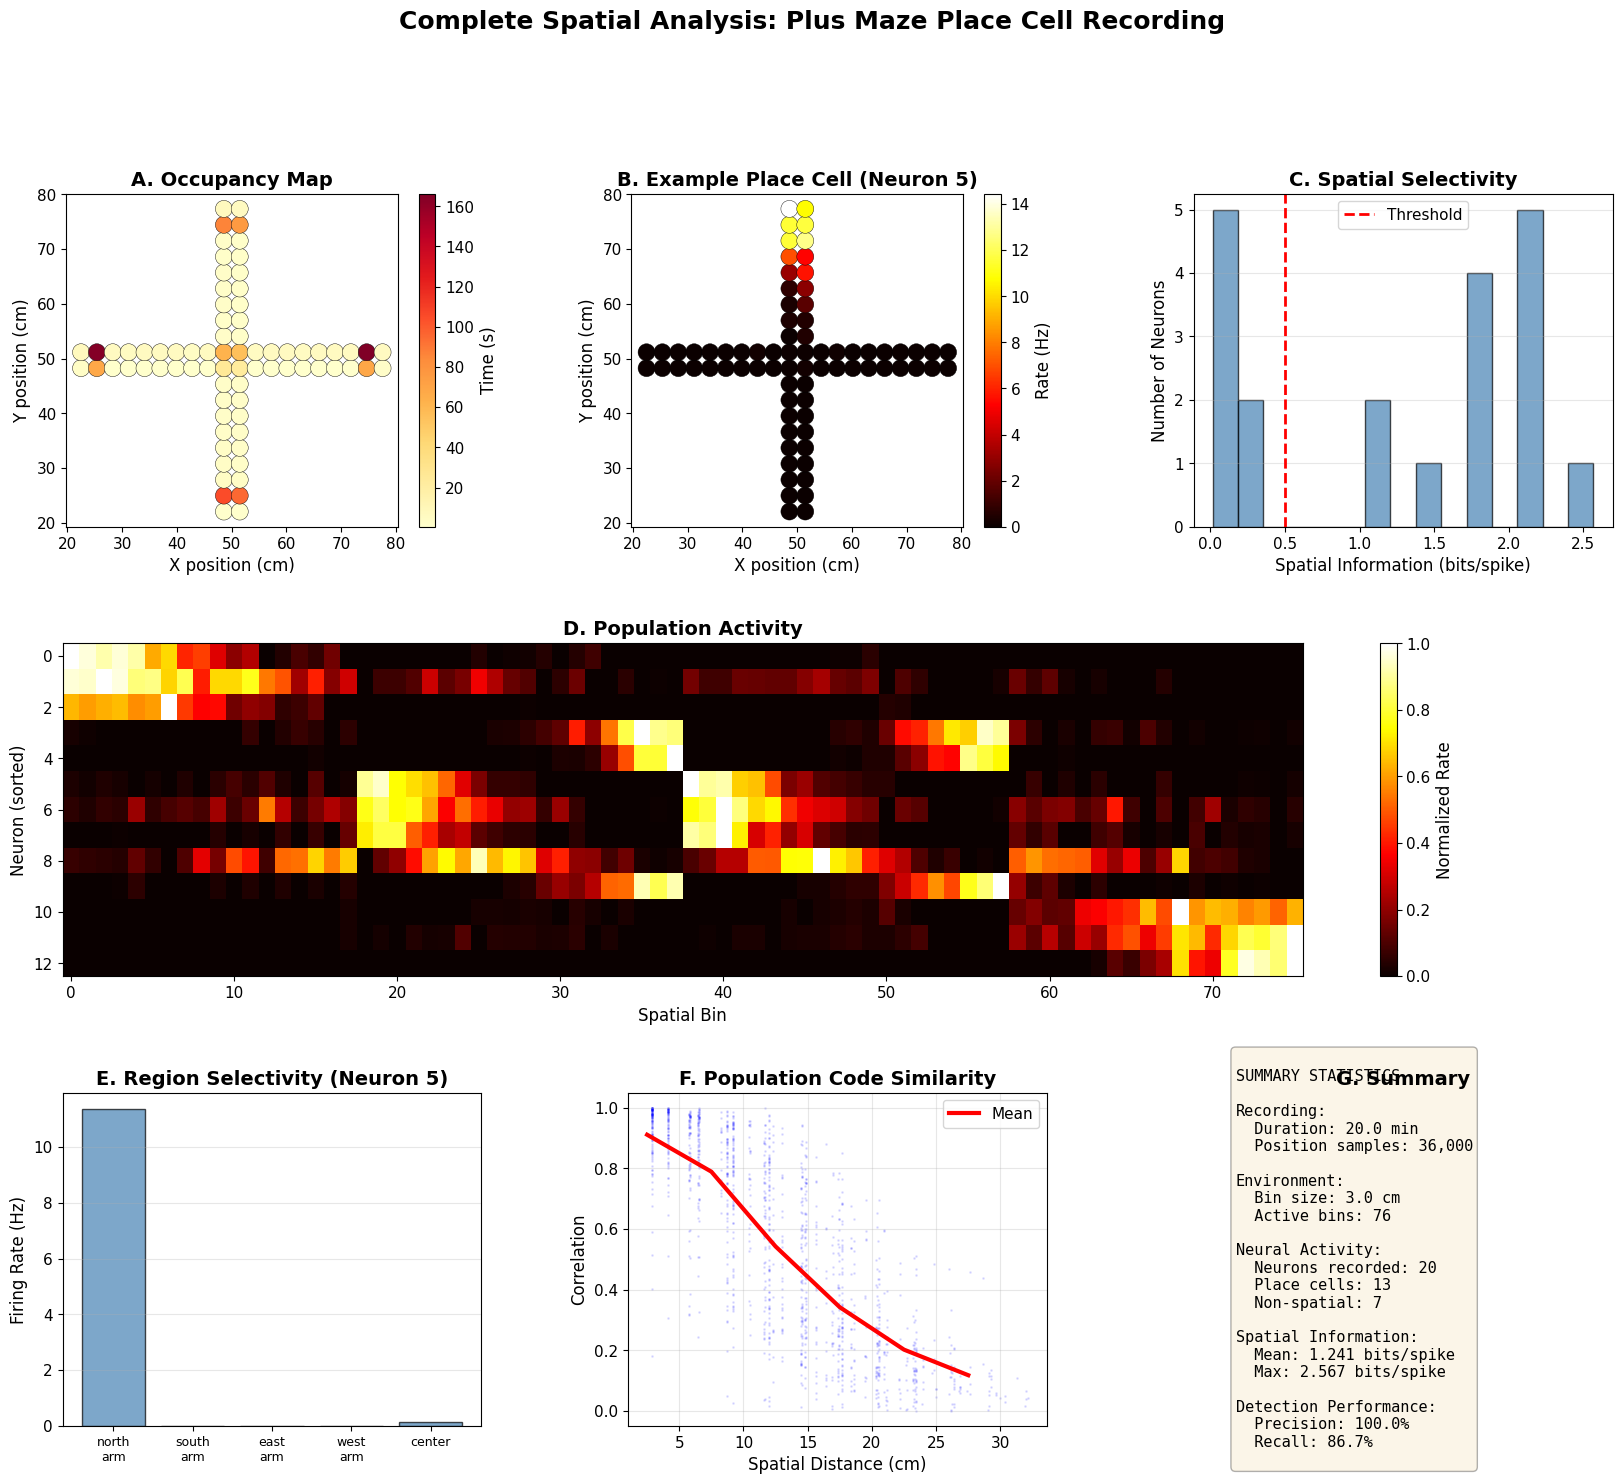


Figure saved to /tmp/place_cell_analysis.png


In [21]:
# Create multi-panel summary figure
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(3, 3, figure=fig, hspace=0.35, wspace=0.35)

# Panel A: Trajectory with occupancy
ax_a = fig.add_subplot(gs[0, 0])
scatter_a = ax_a.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=occupancy_time,
    s=150,
    cmap="YlOrRd",
    edgecolors="black",
    linewidth=0.3,
)
ax_a.set_xlabel("X position (cm)")
ax_a.set_ylabel("Y position (cm)")
ax_a.set_title("A. Occupancy Map", fontweight="bold")
ax_a.set_aspect("equal")
plt.colorbar(scatter_a, ax=ax_a, label="Time (s)")

# Panel B: Example place cell
ax_b = fig.add_subplot(gs[0, 1])
best_neuron = sorted_neurons[0][0]
scatter_b = ax_b.scatter(
    env.bin_centers[:, 0],
    env.bin_centers[:, 1],
    c=place_fields[best_neuron],
    s=150,
    cmap="hot",
    edgecolors="black",
    linewidth=0.3,
)
ax_b.set_xlabel("X position (cm)")
ax_b.set_ylabel("Y position (cm)")
ax_b.set_title(f"B. Example Place Cell (Neuron {best_neuron})", fontweight="bold")
ax_b.set_aspect("equal")
plt.colorbar(scatter_b, ax=ax_b, label="Rate (Hz)")

# Panel C: Spatial information distribution
ax_c = fig.add_subplot(gs[0, 2])
info_values = list(spatial_information.values())
ax_c.hist(info_values, bins=15, alpha=0.7, edgecolor="black", color="steelblue")
ax_c.axvline(
    place_cell_threshold, color="red", linestyle="--", linewidth=2, label="Threshold"
)
ax_c.set_xlabel("Spatial Information (bits/spike)")
ax_c.set_ylabel("Number of Neurons")
ax_c.set_title("C. Spatial Selectivity", fontweight="bold")
ax_c.legend()
ax_c.grid(True, alpha=0.3, axis="y")

# Panel D: Population heatmap
ax_d = fig.add_subplot(gs[1, :])
im_d = ax_d.imshow(
    population_normalized[sort_order, :],
    aspect="auto",
    cmap="hot",
    interpolation="nearest",
)
ax_d.set_xlabel("Spatial Bin")
ax_d.set_ylabel("Neuron (sorted)")
ax_d.set_title("D. Population Activity", fontweight="bold")
plt.colorbar(im_d, ax=ax_d, label="Normalized Rate")

# Panel E: Region selectivity for top neurons
ax_e = fig.add_subplot(gs[2, 0])
neuron_to_plot = sorted_neurons[0][0]
rates = [region_rates[neuron_to_plot][name] for name in arm_names]
rates = [0 if np.isnan(r) else r for r in rates]
ax_e.bar(range(len(arm_names)), rates, color="steelblue", edgecolor="black", alpha=0.7)
ax_e.set_xticks(range(len(arm_names)))
ax_e.set_xticklabels([name.replace("_", "\n") for name in arm_names], fontsize=9)
ax_e.set_ylabel("Firing Rate (Hz)")
ax_e.set_title(f"E. Region Selectivity (Neuron {neuron_to_plot})", fontweight="bold")
ax_e.grid(True, alpha=0.3, axis="y")

# Panel F: Population correlation vs distance
ax_f = fig.add_subplot(gs[2, 1])
ax_f.scatter(spatial_distances, correlations, s=1, alpha=0.1, c="blue")
ax_f.plot(bin_centers, binned_corr, "r-", linewidth=3, label="Mean")
ax_f.set_xlabel("Spatial Distance (cm)")
ax_f.set_ylabel("Correlation")
ax_f.set_title("F. Population Code Similarity", fontweight="bold")
ax_f.legend()
ax_f.grid(True, alpha=0.3)

# Panel G: Summary statistics
ax_g = fig.add_subplot(gs[2, 2])
ax_g.axis("off")
summary_text = f"""
SUMMARY STATISTICS

Recording:
  Duration: {timestamps[-1] / 60:.1f} min
  Position samples: {len(timestamps):,}

Environment:
  Bin size: 3.0 cm
  Active bins: {env.n_bins}

Neural Activity:
  Neurons recorded: {len(spike_times)}
  Place cells: {len(place_cell_ids)}
  Non-spatial: {len(non_spatial_ids)}

Spatial Information:
  Mean: {np.mean(info_values):.3f} bits/spike
  Max: {np.max(info_values):.3f} bits/spike

Detection Performance:
  Precision: {precision:.1%}
  Recall: {recall:.1%}
"""
ax_g.text(
    0.1,
    0.5,
    summary_text,
    fontsize=11,
    family="monospace",
    verticalalignment="center",
    bbox={"boxstyle": "round", "facecolor": "wheat", "alpha": 0.3},
)
ax_g.set_title("G. Summary", fontweight="bold")

plt.suptitle(
    "Complete Spatial Analysis: Plus Maze Place Cell Recording",
    fontsize=18,
    fontweight="bold",
    y=0.995,
)
plt.savefig("/tmp/place_cell_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

print("\nFigure saved to /tmp/place_cell_analysis.png")

## Best Practices and Recommendations

Based on this complete workflow, here are key best practices:

### 1. Data Quality
- **Always check position tracking quality**: Remove periods with missing data or tracking errors
- **Verify sampling rate**: Ensure consistent timing for spike-position alignment
- **Filter outliers**: Remove impossible positions or velocities

### 2. Spatial Discretization
- **Choose appropriate bin_size**: 2-5 cm for rodents, scale with arena size
- **Balance resolution vs statistics**: Smaller bins = better resolution but fewer samples per bin
- **Use infer_active_bins**: Automatically filter unvisited areas
- **Set bin_count_threshold**: Require minimum occupancy (e.g., 5-10 samples)

### 3. Firing Rate Calculation
- **Always normalize by occupancy**: Use spikes/time, not raw spike counts
- **Filter low-occupancy bins**: Exclude bins with <100ms occupancy
- **Consider smoothing**: Gaussian smoothing can reduce noise but may blur fine details
- **Report both raw and smoothed**: Show both for transparency

### 4. Place Cell Classification
- **Use multiple metrics**: Spatial information, peak rate, field size
- **Compare to shuffled controls**: Ensure selectivity isn't by chance
- **Report thresholds clearly**: Document criteria for classification
- **Validate visually**: Always inspect firing rate maps

### 5. Population Analysis
- **Normalize before comparing**: Scale firing rates to [0, 1] or z-scores
- **Account for sampling bias**: Some locations may be over-represented
- **Use cross-validation**: Test decoding on held-out data

### 6. Reproducibility
- **Document parameters**: Save all analysis parameters (bin_size, thresholds, etc.)
- **Version control**: Track code and parameter changes
- **Save intermediate results**: Don't recompute expensive analyses
- **Create analysis scripts**: Automate from raw data to figures

### 7. Visualization
- **Use appropriate colormaps**: 'hot' for firing rates, 'viridis' for continuous data
- **Include scale bars and units**: Always label axes with units
- **Show sample sizes**: Report n for all statistics
- **Create summary figures**: Multi-panel figures for comprehensive view

## Key Takeaways

Congratulations! You've completed a full spatial neuroscience analysis pipeline:

1. **Raw data processing**: Position tracking and spike times → spatial bins

2. **Environment creation**: Use `Environment.from_samples()` with appropriate parameters

3. **Occupancy computation**: Essential for normalizing neural activity

4. **Place field calculation**: Occupancy-normalized firing rate maps

5. **Spatial information**: Quantitative metric for spatial selectivity

6. **Place cell detection**: Classify neurons by spatial tuning

7. **Multi-region analysis**: Compare activity across maze compartments

8. **Population coding**: Ensemble-level spatial representation

9. **Publication figures**: Create comprehensive, clear visualizations

**This workflow is directly applicable to your own data!** Simply replace the synthetic data with your actual tracking and spike data.

## Extensions and Next Steps

To extend this analysis, consider:

1. **Temporal analysis**: How do place fields change over time? (stability, remapping)
2. **Decoding**: Predict position from population activity (Bayesian decoding)
3. **Trajectory analysis**: Analyze paths, running speed effects
4. **Grid cells**: Detect hexagonal firing patterns (autocorrelation)
5. **Theta sequences**: Time-compressed replay within theta cycles
6. **Multi-session alignment**: Compare place fields across days
7. **State-dependent activity**: Different firing in different behavioral states

## Additional Resources

- **neurospatial documentation**: Full API reference and examples
- **Previous notebooks**: Review specific topics (layouts, regions, transforms)
- **Scientific papers**:
  - O'Keefe & Dostrovsky (1971) - Original place cell discovery
  - Skaggs et al. (1993) - Spatial information metric
  - Wilson & McNaughton (1993) - Population coding

Thank you for completing this tutorial series!